### Common Patterns

- This is based on the anthropic post - https://www.anthropic.com/research/building-effective-agents
 and this tutorial is from langchain for langgraph1. **Workflow**:
    1. Create a scaffolding of predefined code paths around LLM calls
    2. LLMs directs control flow through predefined code paths
2. Agent: Remove this scaffolding (LLM directs its own actions, responds to feedback)

In [ ]:
! pip install wikipedia duckduckgo-search langchain

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=ea26a4085a24ac082014602969b406a466b9d871112cebd600559de679abfaa4
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


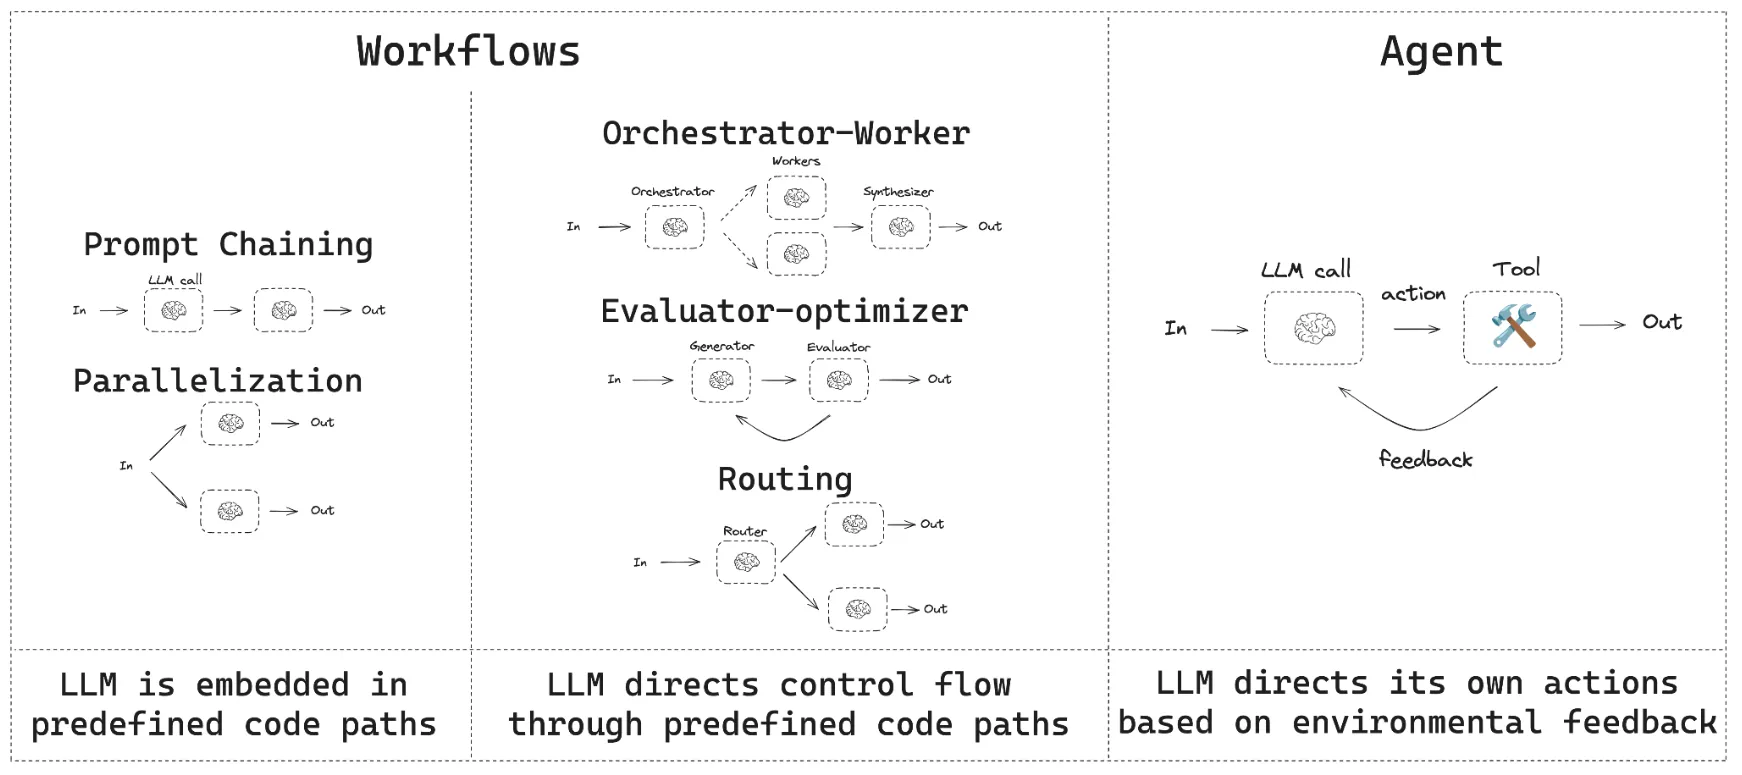

### Why Frameworks?

- Implementing these patterns *does not* require a framework like LangGraph.
- LangGraph aims to *minimize* overhead of implementing these patterns.
- LangGraph provides supporting infrastructure underneath *any**workflow / agent:
    - **Persistence**
        - Memory
        - Human-In-The-Loop
    - **Streaming**
        - From any LLM call or step in workflow / agent
    - **Deployment**
        - Testing, debugging, and deploying

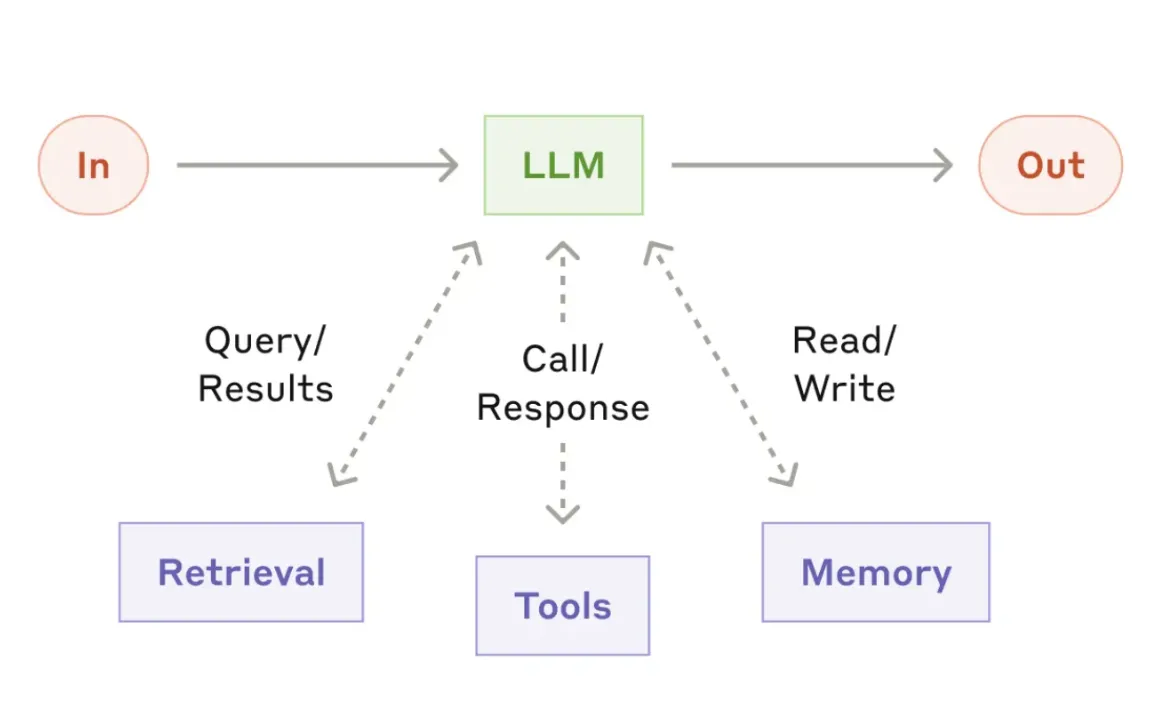

In [ ]:
! pip install langchain_core langchain-anthropic langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import getpass
def _set_env(var):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY: ··········


In [ ]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

relationship between calcium CT score and high cholesterol correlation atherosclerosis
This search will help find medical research and information about how coronary calcium scores are connected to cholesterol levels and cardiovascular health.


In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'toolu_01E1gU3su6TU7LLQTq7F9QEi',
  'type': 'tool_call'}]

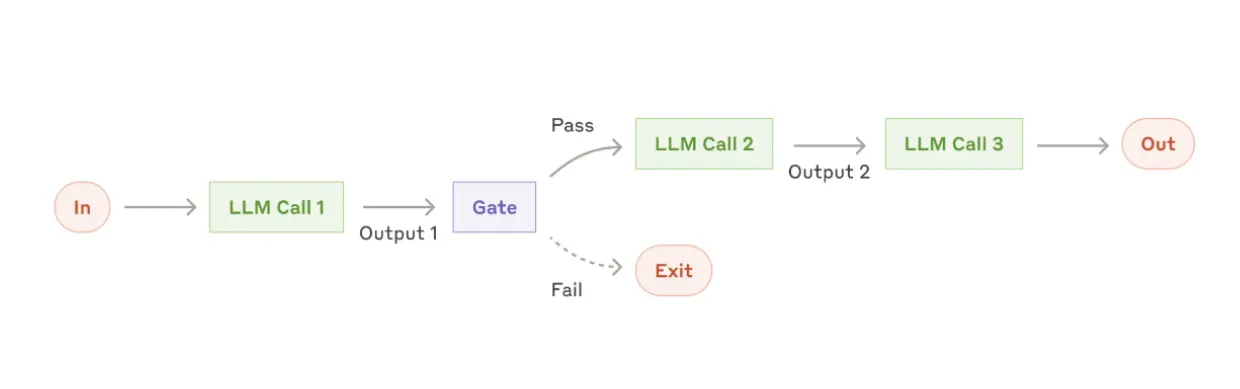

Each LLM call processes the output of the previous one:

- E.g., when decomposing a task into multiple LLM calls has benefit.

Example:

- Take a topic, LLM makes a joke, check the joke, improve it twice

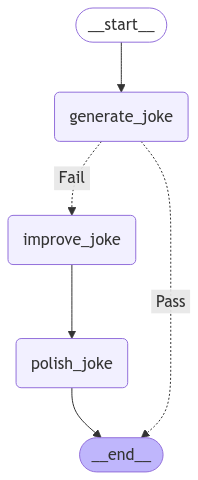

Initial joke:
Here's a short cat joke:

What do you call a cat that becomes a priest?
A paw-ther!

--- --- ---

Improved joke:
Here's the cat joke with more wordplay:

What do you call a cat that becomes a priest?
A paw-ther! He's purr-fect for the paw-sition and takes his holy meow-ders very seriously!

(Adding "purr-fect," "paw-sition," and "meow-ders" [orders] creates a chain of cat-related puns that build on the original punchline!)

--- --- ---

Final joke:
Here's the joke with a surprising twist:

What do you call a cat that becomes a priest?
A paw-ther! He's purr-fect for the paw-sition and takes his holy meow-ders very seriously... until they caught him selling catnip behind the cathedral! Now he's in purr-gatory!

(The twist subverts expectations by turning the seemingly pious cat-priest into a humorous catnip dealer, while still maintaining the cat pun theme with "purr-gatory" as the final punchline!)


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Parallelization
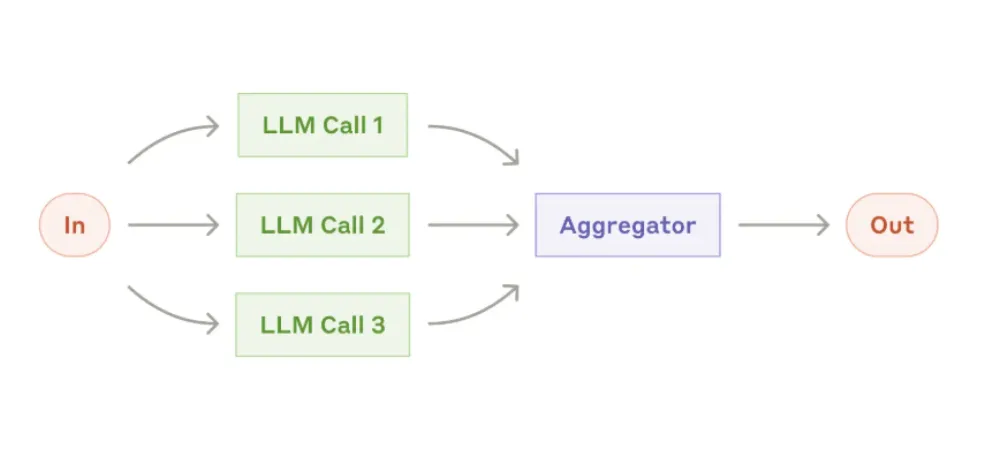

- Sub-tasks can be parallelized.
    - E.g., when you want multi-perspectives for one task  multi-query for RAG).
    - E.g., when independent tasks can be performed w/ different prompts.

Example:

- Take a topic, create a joke, story, and poem

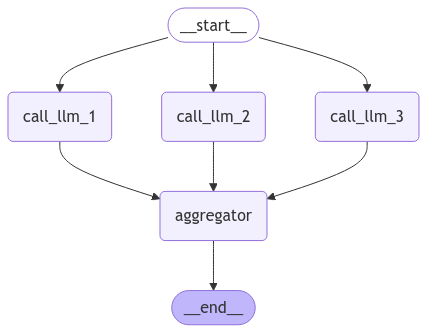

Here's a story, joke, and poem about cats!

STORY:
Here's a story about cats:

The Secret Lives of Alley Cats

Luna and Shadow were two alley cats who lived in the bustling streets of downtown. Luna, with her sleek silver fur and bright blue eyes, was known for her graceful movements and clever wit. Shadow, true to his name, was a mysterious black cat with golden eyes that seemed to glow in the dark.

Every night, while the humans slept, Luna and Shadow would meet at their favorite rooftop spot above an old Italian restaurant. The owner, a kind-hearted man named Marco, would often leave scraps of tuna and chicken for them near the back door. But tonight was different.

As Luna arrived at their meeting spot, Shadow was pacing nervously. "You won't believe what I discovered," he mewed excitedly. "There's a hidden garden behind the old library, and it's full of catnip!"

Luna's whiskers twitched with interest. Together, they embarked on an adventure through the city's narrow alleyways and

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Routing
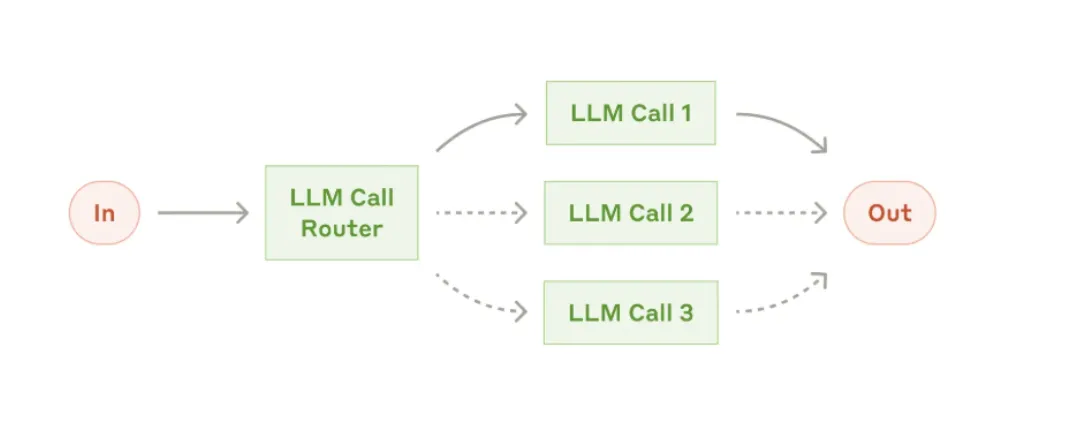

Routing classifies an input and directs it to a specialized followup task.

- E.g., when routing a question to different retrieval systems.

Example:

- Route an input between joke, story, and poem

In [ ]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [ ]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

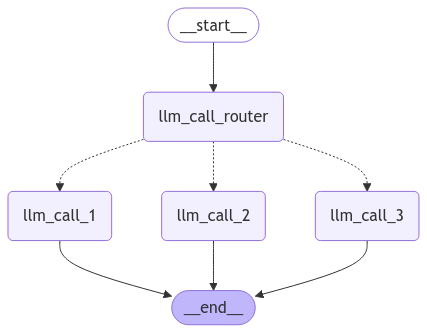

Write a joke
Here's a cat joke for you:

Why don't cats like online shopping?

They prefer a cat-alog!

😺 (Ba dum tss!)


In [ ]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
# display(Image(router_workflow.get_graph().draw_mermaid_png()))
# state = router_workflow.invoke({"input": "Write me a joke about cats"})
# print(state["output"])

# display(Image(router_workflow.get_graph().draw_mermaid_png()))
# state = router_workflow.invoke({"input": "Tell me a story about the adventures of a cat."})
# print(state["output"])

# Show the workflow
# display(Image(router_workflow.get_graph().draw_mermaid_png()))
# state = router_workflow.invoke({"input": "Write a poem about cats"})
# print(state["output"])

### **Orchestrator-Worker**

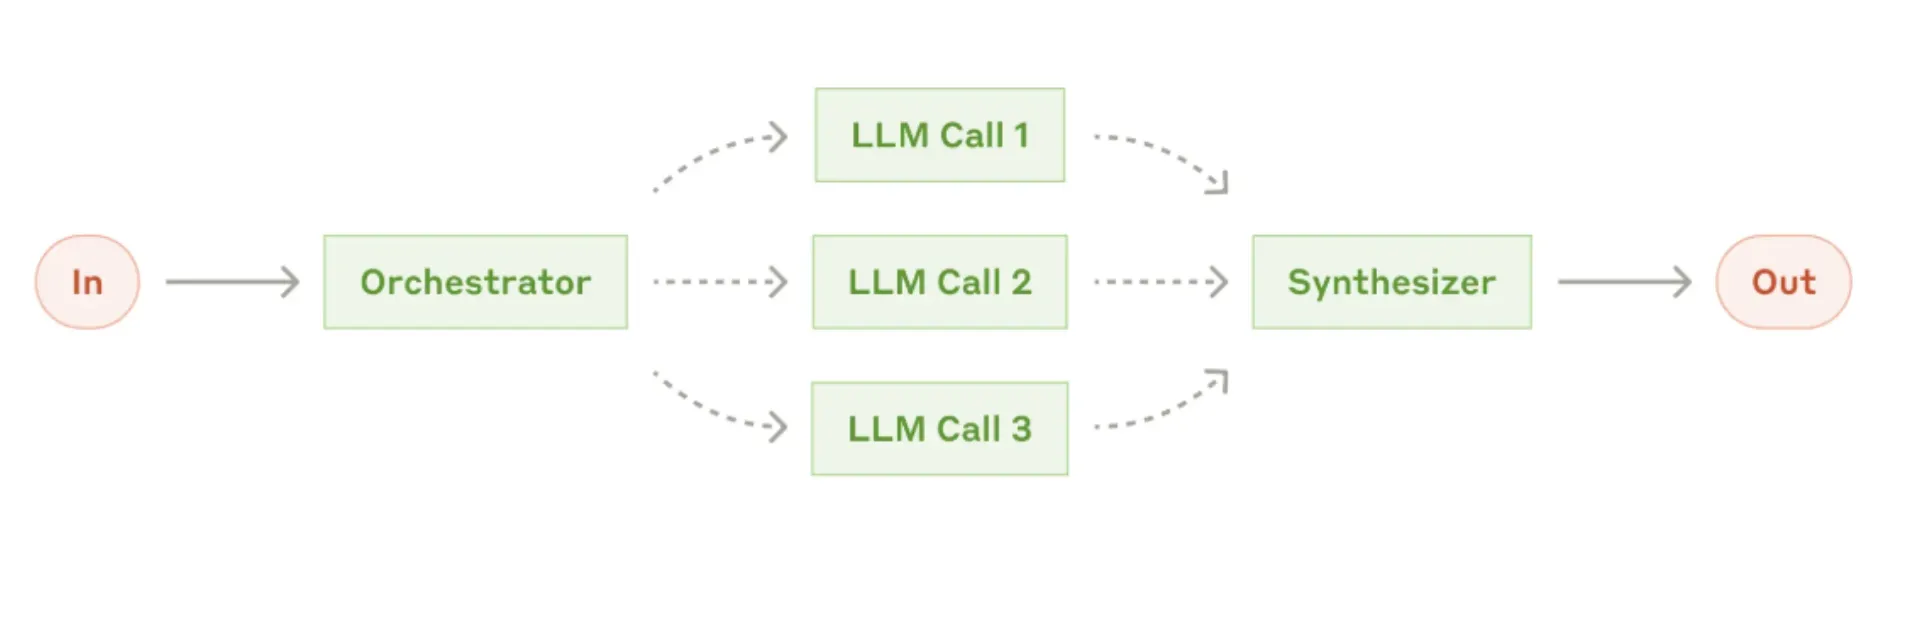![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/c2810b1e-a85a-492f-bc51-5aa2decfa5ac/2638dc93-ef9d-46d1-a7db-b2e8bbd5d51c/image.png)

Orchestrator breaks down a task and delegates each sub-task to workers.

- E.g., planning a report where LLM can determine the number of sections.

Example

- Take a topic, plan a report of section, have each worker write a section

In [ ]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [ ]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [ ]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

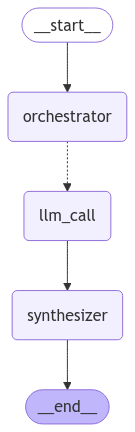

In [ ]:
from langgraph.constants import Send

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

Here's a draft report section:

Introduction to LLM Scaling Laws

Scaling laws in Large Language Models (LLMs) represent fundamental empirical relationships that describe how model performance improves as key parameters like model size, dataset size, and compute resources increase. These mathematical relationships have become crucial guiding principles in modern artificial intelligence development, helping researchers and organizations optimize their approach to building increasingly capable language models.

The discovery of scaling laws marked a pivotal moment in AI research, first formally described in seminal work by OpenAI researchers in 2020. Their research demonstrated that model performance follows surprisingly predictable patterns when scaling up various dimensions, often following power-law relationships. This finding transformed what was previously considered an art of model architecture design into a more systematic engineering challenge.

At their core, scaling laws reveal that:
- Model performance improves smoothly and predictably with increased compute and data
- Larger models generally perform better than smaller ones, following a power-law relationship
- There are optimal ratios between model size, dataset size, and compute budget
- Performance improvements from scaling continue far beyond current practical limits

The importance of scaling laws cannot be overstated in modern AI development. They provide:
- Strategic guidance for resource allocation in model development
- Ability to forecast performance improvements
- Framework for comparing different architectural approaches
- Understanding of fundamental limits and trade-offs

Historical context is essential for understanding scaling laws' significance. Before their discovery, progress in language models was often driven by architectural innovations and engineering intuition. The emergence of transformer architectures in 2017 set the stage for scaling experiments that would reveal these underlying patterns. Early models like GPT-2 and BERT provided initial hints at scaling benefits, but it wasn't until systematic studies with larger models that the full implications became clear.

These principles have directly influenced the development trajectory of modern LLMs. Companies like OpenAI, Google, and Anthropic have leveraged scaling laws to inform their development strategies, leading to models like GPT-3, PaLM, and Claude. The laws continue to guide decisions about where to invest resources and how to optimize training approaches.

Understanding scaling laws is fundamental for anyone working in AI development, as they provide the theoretical foundation for many practical decisions in model development and deployment. They help answer critical questions about resource allocation, model architecture choices, and performance expectations. As the field continues to advance, scaling laws remain a central framework for understanding and pushing the boundaries of what's possible with language models.

---

Here's a draft report section on Fundamental Scaling Relationships:

Fundamental Scaling Relationships
================================

The field of large language models has been fundamentally shaped by the discovery and validation of consistent scaling laws that govern model performance. These mathematical relationships provide crucial insights into how different factors - including computation, model size, and dataset size - interact to determine model capabilities.

Computational Scaling Laws
-------------------------

Kaplan et al.'s seminal 2020 paper "Scaling Laws for Neural Language Models" established several key relationships that have proven remarkably robust across subsequent research:

1. Performance (loss) improves smoothly as compute and dataset size are increased
2. Larger models are significantly more sample-efficient
3. There exists an optimal model size for a given compute budget

The core relationship between model performance and compute follows a power-law:

L(C) ∝ C^(-0.050)

where L is the loss and C is the compute budget. This relationship holds across multiple orders of magnitude, suggesting fundamental limits to efficiency improvements through architectural innovation alone.

Model Size Scaling
-----------------

The relationship between model size (N parameters) and performance follows a similar power-law:

L(N) ∝ N^(-0.076)

This indicates that larger models consistently perform better, but with diminishing returns. Importantly, Kaplan et al. found that for optimal performance, model size should be scaled up in proportion to compute budget according to:

N_opt ∝ C^(0.73)

Dataset Size Requirements
------------------------

The amount of training data required scales approximately linearly with model size. The optimal dataset size D for a given model size N follows:

D_opt ∝ N^(0.74)

This relationship has crucial implications for training efficiency - training significantly beyond D_opt yields diminishing returns, while training with too little data leads to poor performance and overfitting.

Subsequent Developments
----------------------

Recent work has both validated and extended these fundamental relationships:

- Hoffman et al. (2022) demonstrated these scaling laws hold for much larger models (up to 175B parameters)
- Scaling laws have been shown to apply across different model architectures and training objectives
- Research has revealed task-specific scaling behaviors for capabilities like few-shot learning

However, some important refinements have emerged:

1. The emergence of capabilities may not follow smooth scaling (discontinuous improvements)
2. Different tasks and metrics may follow distinct scaling patterns
3. The importance of data quality increases with scale

Practical Implications
---------------------

These scaling laws have profound practical implications for ML development:

- They enable principled decisions about compute/model/data tradeoffs
- They allow reliable prediction of required resources for target performance levels
- They highlight the continued importance of scale in advancing capabilities

However, they also point to fundamental challenges:

- Linear increases in performance require exponential increases in compute
- Data requirements grow nearly linearly with model size
- Optimal scaling requires balanced growth across multiple dimensions

Current research continues to explore these relationships at ever-larger scales while seeking approaches that might enable more favorable scaling behavior.

Understanding and applying these scaling laws is crucial for both research and practical development of large language models. They provide a mathematical framework for reasoning about tradeoffs and requirements while highlighting the fundamental challenges that must be addressed to advance the field.

---

Here's a draft of the "Empirical Evidence and Observations" section:

Empirical Evidence and Observations

The theoretical foundations of scaling laws in language models have been extensively validated through empirical observations across multiple research efforts and model implementations. This section examines key experimental findings that demonstrate how model performance scales with compute, data, and model size.

Industry-Leading Model Results

OpenAI's landmark scaling experiments with GPT-3 provided some of the first comprehensive evidence for predictable scaling behavior in large language models. Their results showed that model performance, measured by cross-entropy loss, improved smoothly as a power-law function of compute and model size. Similar scaling patterns have been observed in subsequent models like PaLM, LLaMA, and GPT-4, reinforcing the robustness of these relationships.

Key empirical findings include:
- Loss decreases approximately as a power-law with compute budget
- Performance scales roughly logarithmically with dataset size
- Larger models consistently outperform smaller ones when trained on sufficient data
- Benefits from scale continue well beyond previous assumed saturation points

Cross-Organization Validation

Multiple research labs and companies have independently verified scaling law behaviors:

- Google's experiments with PaLM demonstrated consistent scaling across multiple model sizes up to 540B parameters
- DeepMind's Chinchilla study refined compute-optimal scaling ratios
- Meta's LLaMA results showed efficient scaling with architectural improvements
- Anthropic's constitutional AI work validated scaling patterns in alignment-focused training

Task-Specific Scaling

Experimental data reveals that scaling behavior varies across different capabilities:

- Reasoning and mathematical tasks often show steeper scaling curves
- Basic language modeling tasks demonstrate more gradual improvements
- Some capabilities appear to emerge suddenly at specific scale thresholds
- Different architectural choices can affect scaling efficiency for specific tasks

Data Quality Effects

Recent studies have highlighted the importance of data quality in scaling behavior:

- High-quality filtered datasets often show better scaling properties
- Diverse data sources improve model robustness
- Data deduplication impacts optimal scaling ratios
- Training on specialized domains can alter scaling curves

Efficiency Improvements

Empirical observations have led to practical improvements in scaling efficiency:

- Optimal parameter/compute ratios identified through systematic studies
- Architecture modifications that improve scaling coefficient
- Training strategies that better utilize increased model capacity
- Dataset curation methods that enhance scaling benefits

Limitations and Challenges

Experimental data has also revealed important limitations:

- Diminishing returns in certain task domains
- Resource constraints affecting optimal scaling choices
- Implementation challenges at extreme scales
- Varying reliability of scaling predictions across different contexts

Future Implications

Ongoing empirical work continues to refine our understanding of scaling behavior:

- Investigation of scaling laws in multimodal models
- Exploration of architectural innovations that might alter scaling patterns
- Study of emergence phenomena at different scale thresholds
- Analysis of scaling behavior in specialized domain adaptation

This empirical evidence has been crucial in guiding the development of larger and more capable language models, while also highlighting areas where traditional scaling laws may need refinement or reconsideration. The consistency of these observations across different research efforts provides strong support for the fundamental nature of these scaling relationships in machine learning systems.

[Note: This section could be enhanced with specific numerical results, graphs, and citations from key papers, depending on the intended detail level and format of the overall report.]

---

Here's a draft report section on Compute-Optimal Training:

Compute-Optimal Training

The emergence of scaling laws in machine learning has provided crucial insights into how to optimally allocate computational resources when training large models. This section explores how these empirical relationships inform key training decisions around model architecture, compute budgets, and training duration.

Scaling Laws and Model Size
Recent research has demonstrated that model performance follows predictable power-law relationships with respect to model size, dataset size, and compute budget. These scaling laws suggest that for a given compute budget, there exists an optimal model size that maximizes final model performance. Models that are too small underfit the data, while oversized models suffer from insufficient training given compute constraints.

Key findings from scaling law research include:
- Performance improves smoothly as compute and dataset size increase
- Larger models are more compute-efficient in terms of training FLOPs required to reach a given performance level
- There are diminishing returns to scale, but current models have not yet reached the point of severely diminished returns

Optimal Compute Allocation
When determining how to allocate a fixed compute budget, several key tradeoffs must be considered:

1. Model Size vs. Training Steps
- Larger models learn more efficiently per training step
- But require more compute per step
- Optimal balance depends on total compute budget

2. Batch Size Selection
- Larger batches enable better hardware utilization
- But show diminishing returns in training efficiency
- Optimal batch size typically scales with compute budget

3. Dataset Size Requirements
- Dataset size should scale approximately linearly with model size
- Insufficient data leads to premature convergence
- Extra data has minimal value once model capacity is saturated

Training Duration Guidelines
Research suggests the following principles for optimal training duration:

- Models should be trained until performance plateaus on the validation set
- Larger models typically benefit from proportionally longer training
- Early stopping can be counterproductive for large models that learn gradually
- Training schedule should be adjusted based on model scale and task complexity

Practical Recommendations
For practical applications, we recommend:

1. Start by estimating total available compute budget

2. Use scaling laws to determine optimal model size for that budget
   - Consider both training and inference requirements
   - Account for available hardware constraints

3. Select batch size based on:
   - Hardware capabilities
   - Model size
   - Training stability requirements

4. Plan training duration to reach convergence while staying within compute budget
   - Monitor validation performance
   - Adjust schedule based on observed learning dynamics

Future Considerations
As models continue to scale, several factors may influence optimal training strategies:

- Improved architecture efficiency
- Novel parallelization techniques
- Advanced optimization methods
- Hardware-specific considerations

Understanding and applying these principles of compute-optimal training is crucial for efficient development of large-scale models. Organizations must carefully balance these factors to maximize return on computational investment while meeting their specific performance requirements.

This section demonstrates how scaling laws provide a framework for making informed decisions about model training strategies. By understanding these relationships, practitioners can better optimize their training processes for available compute resources.

---

Here's a draft of the Limitations and Challenges section:

Limitations and Challenges

While scaling laws have proven valuable for understanding and predicting neural network behavior, they face several important limitations and challenges, particularly when applied to extremely large models. This section examines key boundaries and constraints of current scaling laws.

Model Size Extrapolation Uncertainty
Current scaling laws are primarily derived from empirical observations of models up to certain sizes, typically in the hundreds of billions of parameters. Extrapolating these relationships to much larger scales (trillions of parameters and beyond) involves significant uncertainty. The fundamental assumption that observed power-law relationships continue to hold at extreme scales remains unproven. Some researchers suggest there may be unknown inflection points or regime changes that current scaling laws fail to capture.

Computational Resource Constraints
As models scale to enormous sizes, practical limitations of computational resources become increasingly relevant. While scaling laws may predict theoretical performance improvements, hardware constraints, memory limitations, and energy requirements can make achieving these improvements infeasible. The computational cost typically grows faster than model performance, leading to diminishing returns that may not be fully captured by simple scaling relationships.

Data Quality and Quantity Challenges
Scaling laws often assume availability of high-quality training data that grows proportionally with model size. However, obtaining sufficient quantities of diverse, high-quality data becomes increasingly challenging at extreme scales. This can lead to:
- Data exhaustion in specific domains
- Diminishing data quality as datasets expand
- Potential degradation of model performance due to noisy or lower-quality training examples

Architecture-Specific Limitations
Most scaling laws are derived from specific model architectures (typically transformer-based models) and may not generalize well to:
- Novel architectures
- Hybrid systems
- Models with fundamentally different learning mechanisms
This architectural dependency limits the universal applicability of current scaling laws.

Training Dynamics Complexity
Larger models often exhibit more complex training dynamics that may not be well-captured by existing scaling laws, including:
- Increased instability during training
- More complex optimization landscapes
- Emergence of new behaviors not seen in smaller models

Resource Efficiency Considerations
Current scaling laws often focus on raw performance metrics while failing to fully account for:
- Energy efficiency
- Carbon footprint
- Infrastructure costs
- Training time requirements
These factors become increasingly critical at larger scales.

Validation and Testing Challenges
As models grow larger, thoroughly validating their capabilities becomes more challenging:
- Difficulty in comprehensive testing of all model behaviors
- Increased complexity in identifying and measuring failure modes
- Challenges in quantifying uncertainty and reliability

Social and Ethical Implications
Scaling laws typically don't address important social and ethical considerations:
- Privacy concerns with larger models
- Fairness and bias issues
- Environmental impact
- Economic accessibility

Future Research Needs
To address these limitations, several areas require further investigation:
- Development of more comprehensive scaling laws that account for multiple constraints
- Better understanding of the boundaries of current scaling relationships
- Methods for predicting and measuring model capabilities at extreme scales
- Integration of efficiency and resource utilization metrics

Understanding these limitations and challenges is crucial for responsible development and deployment of large-scale AI systems. While scaling laws provide valuable insights, their boundaries and constraints must be carefully considered when applying them to extremely large models. Future research should focus on developing more nuanced and comprehensive scaling relationships that better account for these various limitations.

---

Here's a draft report section on Economic and Practical Implications:

Economic and Practical Implications

The scaling laws observed in large language models have significant economic and practical implications for AI development. This section analyzes the key considerations around costs, hardware requirements, and strategic planning for AI organizations.

Training Costs
The computational requirements for training large language models increase substantially with model size, following approximately cubic scaling relationships. Current estimates suggest training costs for models like GPT-3 (175B parameters) range from $4-12M per training run. These costs stem primarily from:
- Computing infrastructure (GPU/TPU clusters)
- Electricity consumption
- Engineering time and expertise
- Data collection and preparation

The relationship between model size and training cost can be approximated as:
Cost ∝ N^3, where N is the number of parameters

This scaling relationship creates economic barriers to entry for smaller organizations and researchers, potentially concentrating AI development among well-resourced entities.

Hardware Requirements
Training large language models demands specialized hardware configurations:
- High-performance GPUs/TPUs in parallel clusters
- High-bandwidth memory systems
- Fast interconnects between compute units
- Significant storage capacity for training data and checkpoints

Current limitations include:
- Memory constraints on individual accelerators
- Communication overhead between devices
- Cooling requirements and power delivery
- Physical space and facility requirements

These hardware demands affect both capital expenditure and ongoing operational costs.

Strategic Implications
Organizations must carefully consider several strategic factors:

1. Resource Allocation
- Balancing model size vs. training efficiency
- Investment in infrastructure vs. cloud services
- Trade-offs between multiple smaller models and fewer larger ones

2. Development Approach
- Focusing on architecture improvements vs. scale
- Investigating techniques for improved training efficiency
- Exploring alternative approaches like sparse models

3. Competitive Positioning
- Timing of model releases and updates
- Strategic partnerships for resource sharing
- Open source vs. proprietary development

4. Risk Management
- Technical redundancy and failure recovery
- Managing dependencies on hardware suppliers
- Environmental impact considerations

Future Considerations
Several trends may impact the economic landscape:
- Improvements in training efficiency
- New hardware architectures
- Advanced parallelization techniques
- Novel model architectures
- Regulatory requirements

Organizations must maintain flexibility in their strategies while planning for substantial ongoing investments in AI development infrastructure.

Recommendations
1. Develop clear ROI metrics for model development projects
2. Invest in efficiency-improving research
3. Build strategic hardware partnerships
4. Consider hybrid approaches combining different model scales
5. Plan for long-term infrastructure scaling

This analysis highlights the complex interplay between technical scaling laws and economic realities in AI development. Organizations must carefully balance these factors while planning their AI strategies and resource allocations.

---

Here's a draft of the Future Directions section:

Future Directions

The study of scaling laws in artificial intelligence continues to evolve rapidly, pointing toward several promising avenues for future research and development. This section examines emerging trends and potential developments that may shape the trajectory of scaling laws research and its implications for AI advancement.

Emerging Research Directions

1. Multi-modal Scaling Laws
- Investigation of scaling behaviors across combined modalities (text, images, audio, video)
- Understanding interaction effects between different types of data and model architectures
- Development of unified scaling frameworks for multi-modal systems

2. Efficiency-focused Scaling
- Research into architectural innovations that improve scaling efficiency
- Exploration of sparse models and conditional computation
- Development of methods to achieve better performance with smaller compute budgets

3. Biological and Cognitive Parallels
- Further investigation of connections between neural scaling laws and biological systems
- Integration of insights from cognitive science and neuroscience
- Development of more brain-inspired scaling approaches

Methodological Advances

Researchers are likely to develop more sophisticated methods for studying scaling behaviors, including:
- More precise measurement techniques for model capabilities
- Better theoretical frameworks for predicting scaling limits
- Improved tools for analyzing the relationship between model size, data, and performance

Technical Challenges and Opportunities

Several key technical challenges warrant attention:
- Understanding the limits of current scaling trends
- Developing more energy-efficient scaling approaches
- Creating better metrics for measuring model capabilities
- Addressing computational bottlenecks in large-scale training

Implications for AI Development

The future of scaling laws research will likely have significant implications for:

1. Model Architecture Design
- Informed decisions about model size and structure
- More efficient resource allocation
- Better understanding of architecture trade-offs

2. Training Strategies
- Optimized training procedures
- More effective data utilization
- Improved resource planning

3. Industry Applications
- More accurate cost-benefit analyses
- Better prediction of required resources
- More informed investment decisions

Societal and Ethical Considerations

Future developments must address:
- Environmental impact of large-scale AI training
- Accessibility of AI research to smaller organizations
- Ethical implications of increasingly capable AI systems

As scaling laws research continues to mature, we can expect:
1. More nuanced understanding of the relationships between model size, data, and performance
2. Better tools for predicting and optimizing AI system development
3. Increased focus on efficiency and sustainability
4. Greater integration with other fields of AI research

These developments will play a crucial role in shaping the future of AI technology and its applications across various domains.

Open Questions and Research Priorities

Several key questions remain to be addressed:
1. Are there fundamental limits to current scaling approaches?
2. How can we better predict scaling behavior in novel architectures?
3. What are the optimal trade-offs between model size, training data, and compute resources?
4. How can we make scaling more environmentally sustainable?

These questions will likely drive research priorities in the coming years, leading to new insights and methodologies in the field of scaling laws.

Conclusions

The future of scaling laws research promises to be dynamic and impactful, with potential developments affecting both theoretical understanding and practical applications of AI systems. Success in addressing current challenges and open questions will be crucial for the continued advancement of AI technology while ensuring its sustainable and responsible development.

Researchers and practitioners in this field should remain adaptable and forward-thinking, ready to incorporate new insights and methodologies as they emerge. The evolution of scaling laws research will continue to play a vital role in shaping the future of artificial intelligence and its applications across society.

---

Here's a draft conclusion section:

Conclusion

This survey has examined the crucial role of scaling laws in understanding and predicting AI system performance. The key findings reveal several important patterns and implications:

Key Findings:
- Neural network performance follows remarkably consistent power-law relationships across model size, dataset size, and compute
- These scaling laws hold across diverse architectures and tasks, suggesting fundamental principles about deep learning
- Current evidence indicates that performance improvements from scale have not yet plateaued for most tasks
- Compute requirements grow exponentially with performance improvements, highlighting economic and environmental constraints

Practical Takeaways:
- Scaling laws can inform optimal allocation of computational resources and training data
- Organizations can use these relationships to make strategic decisions about model development
- Understanding scaling behavior helps predict required investments for reaching performance targets
- Environmental and computational costs must be carefully weighed against expected benefits

The emergence of reliable scaling laws represents a significant advance in our scientific understanding of artificial intelligence. These mathematical relationships provide a framework for reasoning about AI capabilities and limitations, allowing more systematic approaches to development. As we look to the future, scaling laws will likely play an increasingly important role in:

1. Research Planning: Guiding decisions about model architectures and training approaches
2. Resource Allocation: Optimizing investments in compute, data collection, and model development
3. Capability Forecasting: Predicting future AI system performance and requirements
4. Sustainability Considerations: Balancing performance gains against environmental impact

However, important questions remain about the limits of these scaling relationships and their applicability to novel architectures and tasks. The field must continue to refine our understanding while remaining mindful of both the opportunities and challenges that large-scale AI development presents.

Future development of AI systems will undoubtedly be shaped by our growing understanding of scaling laws. As we push toward more capable AI systems, these relationships will serve as crucial guides for research, development, and deployment decisions. Their study represents a vital bridge between theoretical understanding and practical implementation in the advancement of artificial intelligence.

The implications of scaling laws extend beyond technical considerations to impact broader societal questions about AI development. As we grapple with questions of AI safety, accessibility, and environmental impact, scaling laws provide an essential framework for informed decision-making and responsible progress in the field.

In closing, scaling laws have emerged as a cornerstone of modern AI research and development. Their continued study and application will be crucial in navigating the challenges and opportunities that lie ahead in the advancement of artificial intelligence technology.

Evaluator-optimizer
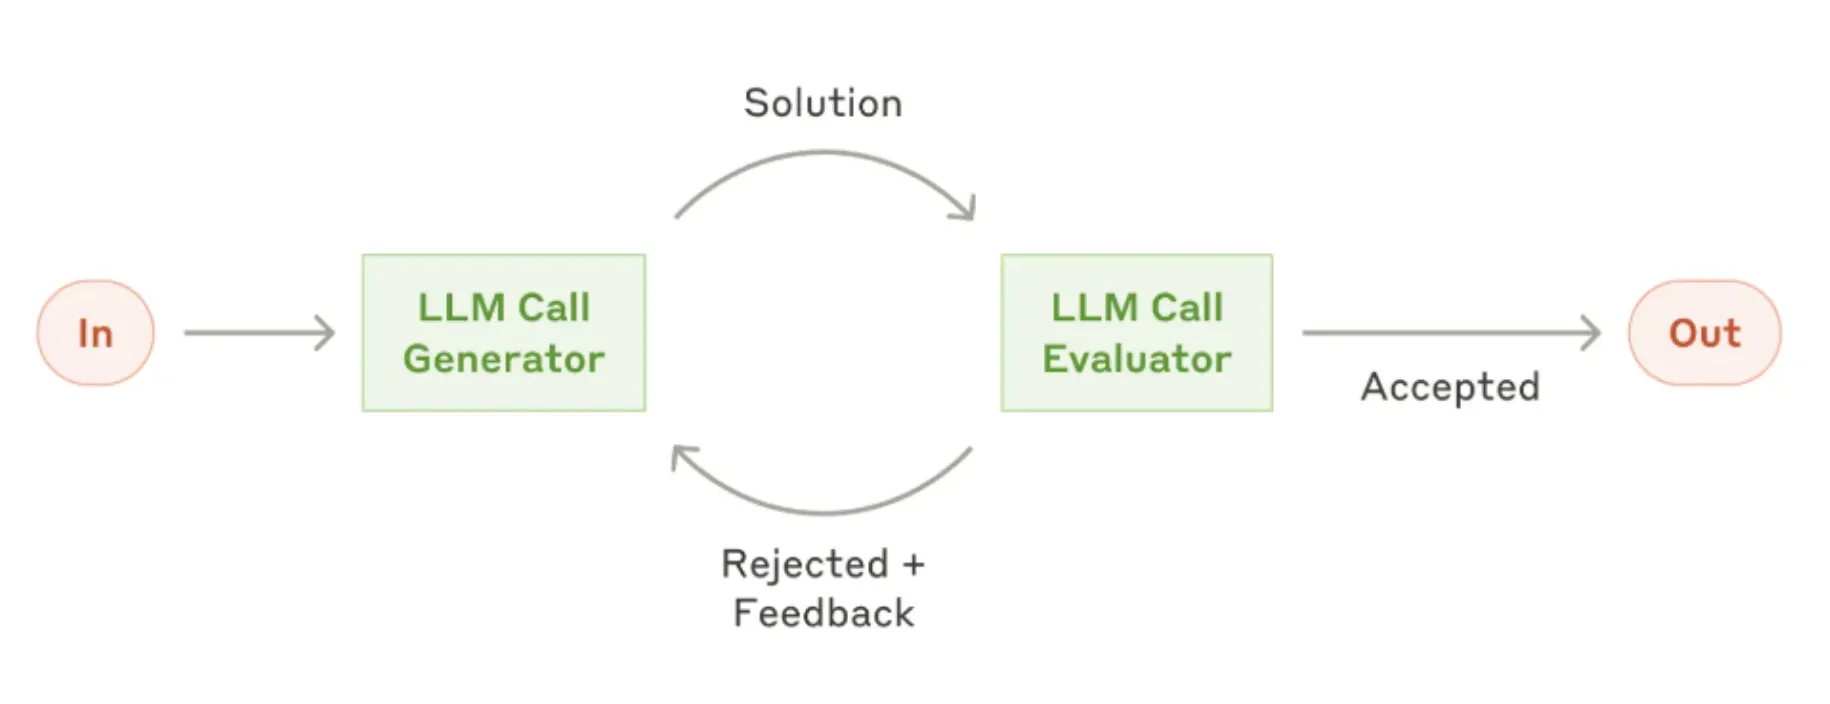
One LLM call generates a response while another provides evaluation and feedback in a loop.

- E.g., when grading the quality of responses from a RAG system (for hallucinations).

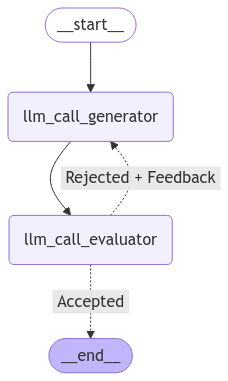

Here's a cat joke for you:

Why don't cats like online shopping?

They prefer a cat-alog!

(This plays on the word "catalog" and cats' tendency to be particular about things!)


In [ ]:

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))


state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])


Agent
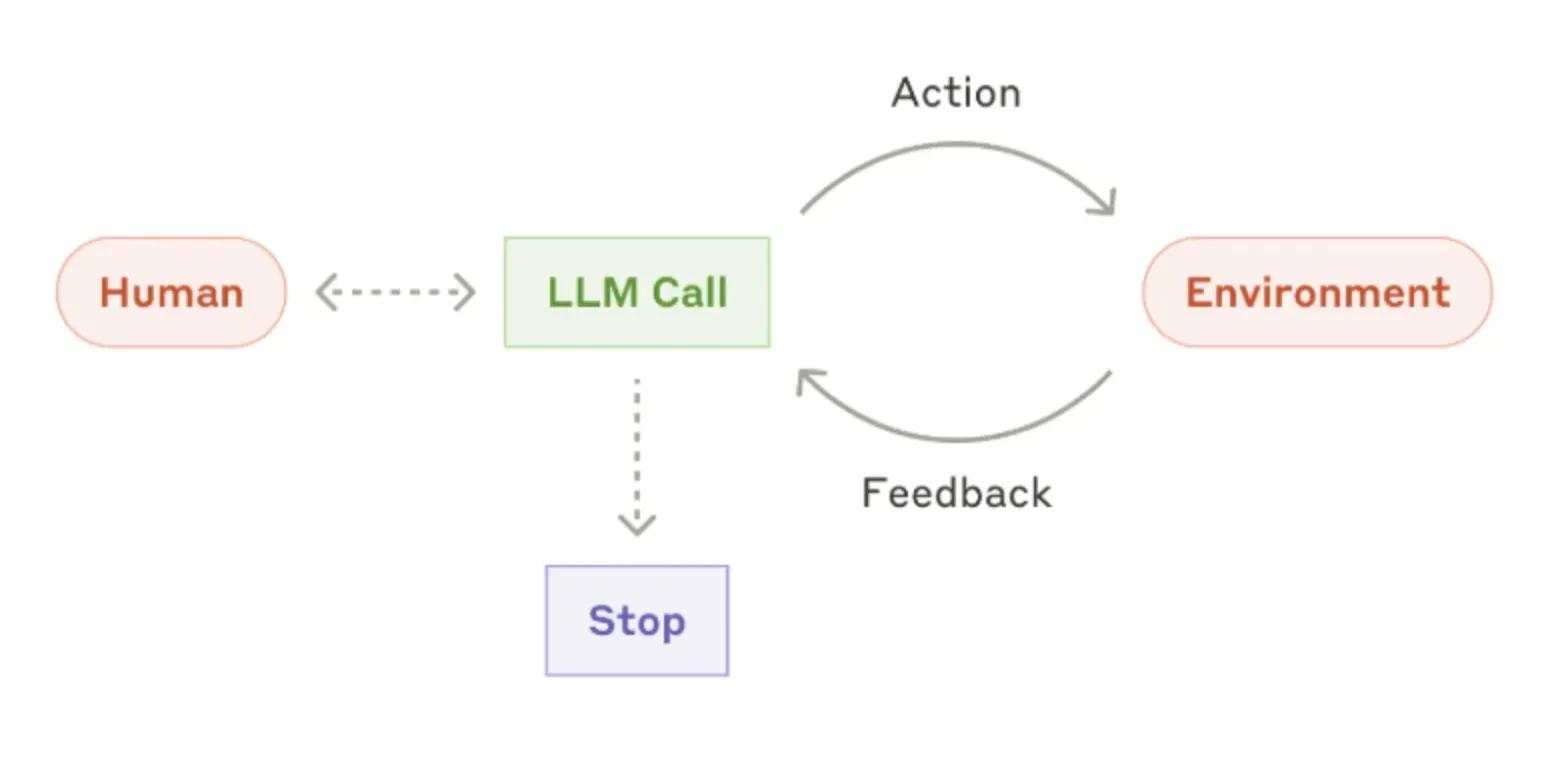

Agents plan, take actions (via tool-calling), and respond to feedback (in a loop).

- E.g., when solving open-ended problems that you cannot lay out as a workflow

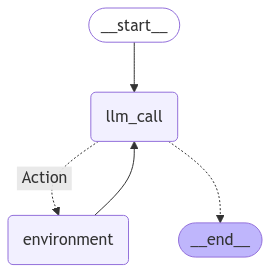

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation. Let's break it down into steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_014pRz5f8ZDjE6wive86TRLd', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_014pRz5f8ZDjE6wive86TRLd)
 Call ID: toolu_014pRz5f8ZDjE6wive86TRLd
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

[{'text': "2. Now, let's take that result (7) and multiply it by 4:", 'type': 'text'}, {'id': 'toolu_01G6W8X5LuWTfzqyjwKQRuCB', 'input': {'a': 7, 'b': 4}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01G6W8X5LuWTfzqyjwKQRuCB)
 Call ID: t

In [ ]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

    # Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()